# Dataset

In [1]:
import torch
import random
import sklearn
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sympy.combinatorics.graycode import GrayCode
torch.cuda.set_device(0)

def inf_train_gen(data, rng=None, batch_size=200):
    if rng is None:
        rng = np.random.RandomState()

    if data == "swissroll":
        data = sklearn.datasets.make_swiss_roll(n_samples=batch_size, noise=1.0)[0]
        data = data.astype("float32")[:, [0, 2]]
        data /= 5
        return data

    elif data == "circles":
        data = sklearn.datasets.make_circles(n_samples=batch_size, factor=.5, noise=0.08)[0]
        data = data.astype("float32")
        data *= 3
        return data

    elif data == "moons":
        data = sklearn.datasets.make_moons(n_samples=batch_size, noise=0.1)[0]
        data = data.astype("float32")
        data = data * 2 + np.array([-1, -0.2])
        return data

    elif data == "8gaussians":
        scale = 4.
        centers = [(1, 0), (-1, 0), (0, 1), (0, -1), (1. / np.sqrt(2), 1. / np.sqrt(2)),
                   (1. / np.sqrt(2), -1. / np.sqrt(2)), (-1. / np.sqrt(2),
                                                         1. / np.sqrt(2)), (-1. / np.sqrt(2), -1. / np.sqrt(2))]
        centers = [(scale * x, scale * y) for x, y in centers]

        dataset = []
        for i in range(batch_size):
            point = rng.randn(2) * 0.5
            idx = rng.randint(8)
            center = centers[idx]
            point[0] += center[0]
            point[1] += center[1]
            dataset.append(point)
        dataset = np.array(dataset, dtype="float32")
        dataset /= 1.414
        return dataset

    elif data == "pinwheel":
        radial_std = 0.3
        tangential_std = 0.1
        num_classes = 5
        num_per_class = batch_size // 5
        rate = 0.25
        rads = np.linspace(0, 2 * np.pi, num_classes, endpoint=False)

        features = rng.randn(num_classes*num_per_class, 2) \
            * np.array([radial_std, tangential_std])
        features[:, 0] += 1.
        labels = np.repeat(np.arange(num_classes), num_per_class)

        angles = rads[labels] + rate * np.exp(features[:, 0])
        rotations = np.stack([np.cos(angles), -np.sin(angles), np.sin(angles), np.cos(angles)])
        rotations = np.reshape(rotations.T, (-1, 2, 2))

        return 2 * rng.permutation(np.einsum("ti,tij->tj", features, rotations))

    elif data == "2spirals":
        n = np.sqrt(np.random.rand(batch_size // 2, 1)) * 540 * (2 * np.pi) / 360
        d1x = -np.cos(n) * n + np.random.rand(batch_size // 2, 1) * 0.5
        d1y = np.sin(n) * n + np.random.rand(batch_size // 2, 1) * 0.5
        x = np.vstack((np.hstack((d1x, d1y)), np.hstack((-d1x, -d1y)))) / 3
        x += np.random.randn(*x.shape) * 0.1
        return x

    elif data == "checkerboard":
        x1 = np.random.rand(batch_size) * 4 - 2
        x2_ = np.random.rand(batch_size) - np.random.randint(0, 2, batch_size) * 2
        x2 = x2_ + (np.floor(x1) % 2)
        return np.concatenate([x1[:, None], x2[:, None]], 1) * 2

    else:
        raise NotImplementedError

class ToyDataset(object):

    def __init__(self, dim, data_file=None, static_data=None):
        if data_file is not None:
            self.static_data = np.load(data_file)
        elif static_data is not None:
            self.static_data = static_data
        else:
            self.static_data = None
        self.dim = dim

    def gen_batch(self, batch_size):
        raise NotImplementedError

    def data_gen(self, batch_size, auto_reset):
        if self.static_data is not None:
            num_obs = self.static_data.shape[0]
            while True:
                for pos in range(0, num_obs, batch_size):
                    if pos + batch_size > num_obs:  # the last mini-batch has fewer samples
                        if auto_reset:  # no need to use this last mini-batch
                            break
                        else:
                            num_samples = num_obs - pos
                    else:
                        num_samples = batch_size
                    yield self.static_data[pos : pos + num_samples, :]
                if not auto_reset:
                    break
                np.random.shuffle(self.static_data)
        else:
            while True:
                yield self.gen_batch(batch_size)

class OnlineToyDataset(ToyDataset):
    def __init__(self, data_name):
        super(OnlineToyDataset, self).__init__(2)
        self.data_name = data_name
        self.rng = np.random.RandomState()

        rng = np.random.RandomState(1)
        samples = inf_train_gen(self.data_name, rng, 5000)
        self.f_scale = np.max(np.abs(samples)) + 1
        self.int_scale = 2 ** 15 / (self.f_scale + 1)
        # print('f_scale,', self.f_scale, 'int_scale,', self.int_scale)

    def gen_batch(self, batch_size):
        return inf_train_gen(self.data_name, self.rng, batch_size)

def get_binmap(discrete_dim, binmode):
    b = discrete_dim // 2 - 1
    all_bins = []
    for i in range(1 << b):
        bx = np.binary_repr(i, width=discrete_dim // 2 - 1)
        all_bins.append('0' + bx)
        all_bins.append('1' + bx)
    vals = all_bins[:]
    if binmode == 'rand':
        print('remapping binary repr with random permute')
        random.shuffle(vals)
    elif binmode == 'gray':
        print('remapping binary repr with gray code')
        a = GrayCode(b)
        vals = []
        for x in a.generate_gray():
            vals.append('0' + x)
            vals.append('1' + x)
    else:
        assert binmode == 'normal'
    bm = {}
    inv_bm = {}
    for i, key in enumerate(all_bins):
        bm[key] = vals[i]
        inv_bm[vals[i]] = key
    return bm, inv_bm

bm, inv_bm = get_binmap(discrete_dim=32, binmode='gray')
db = OnlineToyDataset(data_name='pinwheel')
int_scale = db.int_scale
plot_size = db.f_scale

def float2bin(samples, bm):
    bin_list = []
    for i in range(samples.shape[0]):
        x, y = samples[i] * int_scale
        bx, by = compress(x), compress(y)
        bx, by = bm[bx], bm[by]
        bin_list.append(np.array(list(bx + by), dtype=int))
    return np.array(bin_list)

def bin2float(samples, inv_bm, discrete_dim=32):
    floats = []
    for i in range(samples.shape[0]):
        s = ''
        for j in range(samples.shape[1]):
            s += str(samples[i, j])
        x, y = s[:discrete_dim//2], s[discrete_dim//2:]
        x, y = inv_bm[x], inv_bm[y]
        x, y = recover(x), recover(y)
        x /= int_scale
        y /= int_scale
        floats.append((x, y))
    return np.array(floats)

def compress(x, discrete_dim=32):
    bx = np.binary_repr(int(abs(x)), width=discrete_dim // 2 - 1)
    bx = '0' + bx if x >= 0 else '1' + bx
    return bx
def recover(bx):
    x = int(bx[1:], 2)
    return x if bx[0] == '0' else -x

def plot_heat(score_func, bm, device):
    w = 100
    size = plot_size
    x = np.linspace(-size, size, w)
    y = np.linspace(-size, size, w)
    xx, yy = np.meshgrid(x, y)
    xx = np.reshape(xx, [-1, 1])
    yy = np.reshape(yy, [-1, 1])
    heat_samples = float2bin(np.concatenate((xx, yy), axis=-1), bm)
    heat_samples = torch.from_numpy(np.float32(heat_samples)).to(device)
    heat_score = F.softmax(-score_func(heat_samples).view(1, -1), dim=-1)
    a = heat_score.view(w, w).data.cpu().numpy()
    a = np.flip(a, axis=0)
    plt.imshow(a)
    plt.axis('equal')
    plt.axis('off')
    plt.show()
    plt.close()


remapping binary repr with gray code


# Models and Training Algorithms

In [2]:
import torch.nn as nn
import torch.distributions as dists

class Swish(nn.Module):
    def __init__(self):
        super(Swish, self).__init__()
        self.beta = nn.Parameter(torch.tensor(1.0))

    def forward(self, x):
        return x * torch.sigmoid(self.beta * x)

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dims):
        super(MLP, self).__init__()
        self.input_dim = input_dim

        if isinstance(hidden_dims, str):
            hidden_dims = list(map(int, hidden_dims.split("-")))
        assert len(hidden_dims)
        hidden_dims = [input_dim] + hidden_dims
        self.output_size = hidden_dims[-1]

        list_layers = []

        for i in range(1, len(hidden_dims)):
            list_layers.append(nn.Linear(hidden_dims[i - 1], hidden_dims[i]))
            if i + 1 < len(hidden_dims):  # not the last layer
                list_layers.append(Swish())

        self.main = nn.Sequential(*list_layers)

    def forward(self, z):
        x = self.main(z)
        return x

class MLPScore(nn.Module):
    def __init__(self, input_dim, hidden_dims):
        super(MLPScore, self).__init__()
        self.mlp = MLP(input_dim, hidden_dims)

    def forward(self, z):
        raw_score = self.mlp(z.float())
        return raw_score

class EBM(nn.Module):
    def __init__(self, net, mean=None):
        super().__init__()
        self.net = net
        if mean is None:
            self.mean = None
        else:
            self.mean = nn.Parameter(mean, requires_grad=False)

    def update_mean(self, mean):
        self.mean = nn.Parameter(mean, requires_grad=False)

    def forward(self, x):
        '''
        we define p(x) = exp(-f(x)) / Z, the output of net is f(x)
        '''
        if self.mean is None:
            bd = 0.
        else:
            base_dist = torch.distributions.Bernoulli(probs=self.mean)
            bd = base_dist.log_prob(x).sum(-1)

        logp = self.net(x).squeeze()
        return logp - bd

def energy_discrepancy_neighborhood(energy_net, samples, m_particles=32, w_stable=1.):
    device = samples.device
    bs, dim = samples.shape

    mask = torch.zeros_like(samples)
    mask.scatter_(-1, torch.randint(dim, size=(bs,)).to(device).unsqueeze(-1), 1)
    beri = (samples + mask) % 2.    # [bs, dim]

    mask = torch.zeros(bs, m_particles, dim).to(device)
    mask.scatter_(-1, torch.randint(dim, size=(bs,m_particles,)).to(device).unsqueeze(-1), 1)
    pert_data = (beri.unsqueeze(1) + mask) % 2   # [bs, m_particles, dim]

    pos_energy = energy_net(samples)   # [bs]
    neg_energy = energy_net(pert_data.view(-1, dim)).view(bs, -1)  # [bs, m_particles]
    val = pos_energy.view(bs, 1) - neg_energy
    if w_stable != 0:
        val = torch.cat([val, np.log(w_stable) * torch.ones_like(val[:, :1])], dim=-1)
    
    loss = val.logsumexp(dim=-1).mean()
    return loss

def energy_discrepancy_permutation(energy_net, samples, w_size=32, m_particles=32, w_stable=1.):
    device = samples.device
    bs, dim = samples.shape
    assert dim % w_size == 0

    dup_samples = samples.repeat(m_particles, 1).reshape(m_particles*bs, dim//w_size, w_size)
    pert_ind = torch.argsort(torch.rand(*dup_samples.shape).to(device), dim=-1)
    pert_data = dup_samples.gather(2, pert_ind).reshape(m_particles*bs, dim)

    pos_energy = energy_net(samples)
    neg_energy = energy_net(pert_data).view(m_particles, bs)
    val = pos_energy.view(1, bs) - neg_energy
    if w_stable != 0:
        val = torch.cat([val, np.log(w_stable) * torch.ones_like(val[:1, :])], dim=0)
    
    loss = val.logsumexp(dim=0).mean()
    return loss

def energy_discrepancy_bernoulli(energy_net, samples, epsilon=0.1, m_particles=32, w_stable=1.):
    device = samples.device
    bs, dim = samples.shape

    noise_dist = dists.Bernoulli(probs=epsilon * torch.ones((dim,)).to(device))
    beri = (noise_dist.sample((bs,)) + samples) % 2.    # [bs, dim]
    pert_data = (noise_dist.sample((bs * m_particles,)).view(bs, m_particles, dim) + beri.unsqueeze(1)) % 2.    # [bs, m_particles, dim]

    pos_energy = energy_net(samples)   # [bs]
    neg_energy = energy_net(pert_data.view(-1, dim)).view(bs, -1)  # [bs, m_particles]
    val = pos_energy.view(bs, 1) - neg_energy
    if w_stable != 0:
        val = torch.cat([val, np.log(w_stable) * torch.ones_like(val[:, :1])], dim=-1)
    
    loss = val.logsumexp(dim=-1).mean()
    return loss


# Training Main Loop

In [3]:
import copy
from tqdm import tqdm
import torch.optim as optim

def training_main_loop(db, bm, energy_func, device, algo='ed_bern'):
    ema_energy_func = copy.deepcopy(energy_func)
    ema_energy_func.to(device)
    opt_energy = optim.Adam(energy_func.parameters(), lr=0.002)

    for epoch in range(1000):
        pbar = tqdm(range(100))
        for it in pbar:
            samples = float2bin(db.gen_batch(128), bm)
            samples = torch.from_numpy(np.float32(samples)).to(device)

            if algo == 'ed_bern':
                loss = energy_discrepancy_bernoulli(energy_func, samples)
            elif algo == 'ed_pool':
                loss = energy_discrepancy_permutation(energy_func, samples)
            elif algo == 'ed_grid':
                loss = energy_discrepancy_neighborhood(energy_func, samples)
            else:
                raise NotImplementedError
            
            opt_energy.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(energy_func.parameters(), max_norm=5)
            opt_energy.step()
            
            with torch.no_grad():
                for p, ema_p in zip(energy_func.parameters(), ema_energy_func.parameters()):
                    ema_p.data = ema_p.data * 0.999 + p.data * (1. - 0.999)

            pbar.set_description('epoch: %d, loss: %.4f' % (epoch, loss.item()))

    return ema_energy_func

# Training Discrete EBM using ED-Bern

epoch: 999, loss: 2.1710: 100%|██████████| 100/100 [00:01<00:00, 90.08it/s]


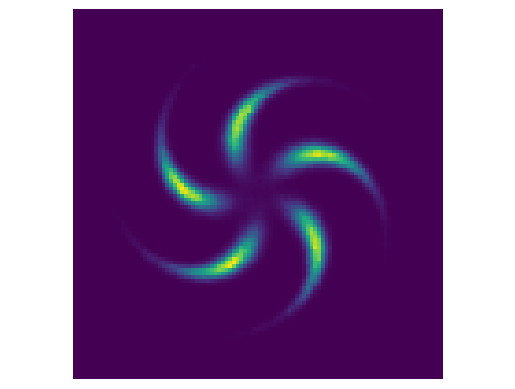

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

samples = float2bin(db.gen_batch(50000), bm)
mean = np.mean(samples, axis=0)
init_dist = torch.distributions.Bernoulli(probs=torch.from_numpy(mean).to(device) * (1. - 2 * 1e-2) + 1e-2)
net = MLPScore(input_dim=32, hidden_dims=[256,256,256,1]).to(device)
energy_func = EBM(net, torch.from_numpy(mean)).to(device)
ema_energy_func = training_main_loop(db, bm, energy_func, device, algo='ed_bern')
plot_heat(ema_energy_func, bm, device)

# Training Discrete EBM using ED-Pool

epoch: 999, loss: 1.2030: 100%|██████████| 100/100 [00:01<00:00, 89.16it/s]


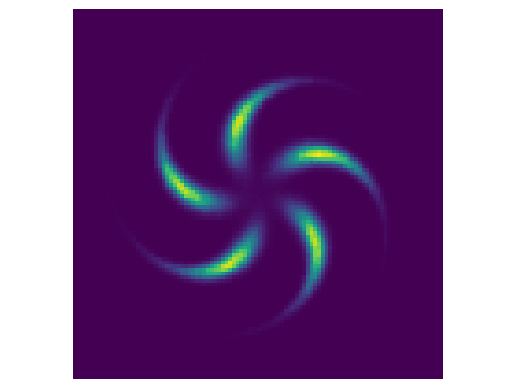

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

samples = float2bin(db.gen_batch(50000), bm)
mean = np.mean(samples, axis=0)
init_dist = torch.distributions.Bernoulli(probs=torch.from_numpy(mean).to(device) * (1. - 2 * 1e-2) + 1e-2)
net = MLPScore(input_dim=32, hidden_dims=[256,256,256,1]).to(device)
energy_func = EBM(net, torch.from_numpy(mean)).to(device)
ema_energy_func = training_main_loop(db, bm, energy_func, device, algo='ed_pool')
plot_heat(ema_energy_func, bm, device)

# Training Discrete EBM using ED-Grid

epoch: 999, loss: 3.0820: 100%|██████████| 100/100 [00:00<00:00, 129.78it/s]


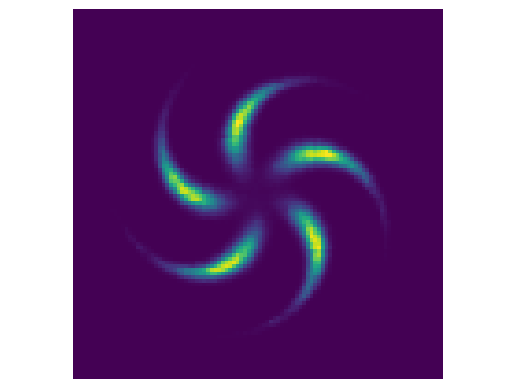

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

samples = float2bin(db.gen_batch(50000), bm)
mean = np.mean(samples, axis=0)
init_dist = torch.distributions.Bernoulli(probs=torch.from_numpy(mean).to(device) * (1. - 2 * 1e-2) + 1e-2)
net = MLPScore(input_dim=32, hidden_dims=[256,256,256,1]).to(device)
energy_func = EBM(net, torch.from_numpy(mean)).to(device)
ema_energy_func = training_main_loop(db, bm, energy_func, device, algo='ed_grid')
plot_heat(ema_energy_func, bm, device)